In [13]:
"""
antenna_opt_GA.py
Skrip lengkap: membangun surrogate DNN (multi-output) lalu jalankan Genetic Algorithm (GA)
untuk mencari kombinasi parameter antena terbaik (gain maksimum, S11 minimum, efisiensi tinggi).

Pastikan menginstall:
pip install tensorflow scikit-learn pandas matplotlib numpy
"""

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Reproducibility
RND_SEED = 42
np.random.seed(RND_SEED)
random.seed(RND_SEED)

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

# -----------------------------
# 1. Konfigurasi & path file
# -----------------------------
#DATA_CSV = 'dataset_patch_rectangular_mixed_DNN.csv' 
DATA_CSV = 'dataset_patch_rectangular_10GHz_2000rows.csv' 

#MODEL_SAVE = "model_baru.h5"
MODEL_SAVE = "model_baru_10ghz.h5"

#RESULTS_DIR = "ga_results"
RESULTS_DIR = "ga_results_10ghz"
os.makedirs(RESULTS_DIR, exist_ok=True)

In [14]:

# -----------------------------
# 2. Parameter untuk optimasi
# -----------------------------
# Kita optimasi 4 parameter input: Panjang_Patch_mm, Lebar_Patch_mm, Tebal_Substrat_mm (tetap 1.6), inset_x atau feed pos?
# Dari diskusi kita: kita gunakan parameter: L_patch, W_patch, inset_x, feed_width
# Rentang berdasarkan perhitungan & praktik:
BOUNDS = {
    'L_patch_mm': (5.8, 7.0),        # range sekitar L ~6.428 ± ~10%
    'W_patch_mm': (8.5, 9.8),       # range sekitar W ~9.129 ± ~7%
    'inset_x_mm': (0.5, 3.5),       # kedalaman inset dari tepi (mm)
    'feed_width_mm': (2.0, 4.0)     # lebar jalur feed (mm)
}

# Input fitur urut sesuai dataset / model:

FEATURE_NAMES = ['er', 'VSWR','Bandwidth_MHz','Resonant_freq_Hz', 'S11_min_dB', 'Peak_gain_dBi', 'Efficiency_pct']
# Untuk surrogate: kita pakai subset input yang relevan:
SURROGATE_INPUT_NAMES = ['er', 'VSWR','Bandwidth_MHz','Resonant_freq_Hz', 'S11_min_dB', 'Peak_gain_dBi', 'Efficiency_pct']
# Target output names
TARGET_NAMES = ['L_mm','W_mm','h_mm']
# -----------------------------
# 3. Utility: load dataset & prepare
# -----------------------------
def load_and_prepare(csv_path=DATA_CSV):
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"Dataset tidak ditemukan: {csv_path}. Upload dataset ke path ini.")

    df = pd.read_csv(csv_path)
    # Check columns
    needed = set(SURROGATE_INPUT_NAMES + TARGET_NAMES)
    missing = needed - set(df.columns)
    if missing:
        raise ValueError(f"Kolom berikut hilang di dataset: {missing}")

    # Jika dataset tidak memiliki kolom 'Tebal_Substrat_mm' bervariasi, tetap berikan nilai  1.6
    # Pastikan tipe float
    df = df.copy()
    df[SURROGATE_INPUT_NAMES] = df[SURROGATE_INPUT_NAMES].astype(float)
    df[TARGET_NAMES] = df[TARGET_NAMES].astype(float)

    return df

# -----------------------------
# 4. Surrogate DNN (train or load)
# -----------------------------
def build_surrogate_model(input_dim, output_dim, units=[128,64,32], dropout=0.15, lr=1e-3):
    model = Sequential()
    model.add(Dense(units[0], activation='relu', input_shape=(input_dim,)))
    model.add(Dropout(dropout))
    for u in units[1:]:
        model.add(Dense(u, activation='relu'))
    model.add(Dense(output_dim, activation='linear'))
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    # Gunakan objek metrics langsung untuk kompatibilitas yang lebih baik
    model.compile(optimizer=opt, 
                  loss=tf.keras.losses.MeanSquaredError(), 
                  metrics=[tf.keras.metrics.MeanAbsoluteError()])
    return model

def train_surrogate(df, model_path=MODEL_SAVE, retrain=False):
    X = df[SURROGATE_INPUT_NAMES].values
    y = df[TARGET_NAMES].values

    # Scaler untuk input dan output
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    Xs = scaler_X.fit_transform(X)
    ys = scaler_y.fit_transform(y)

    # Split
    X_train, X_test, y_train, y_test = train_test_split(Xs, ys, test_size=0.2, random_state=RND_SEED)

    if os.path.exists(model_path) and not retrain:
        print("Memuat model surrogate dari:", model_path)
        try:
            # Coba muat dengan compile=False untuk menghindari masalah deserialisasi metrics
            model = load_model(model_path, compile=False)
            # Compile ulang dengan metrics yang benar (menggunakan objek langsung)
            opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
            model.compile(optimizer=opt, 
                          loss=tf.keras.losses.MeanSquaredError(), 
                          metrics=[tf.keras.metrics.MeanAbsoluteError()])
            print("Model berhasil dimuat dan dikompilasi ulang.")
        except Exception as e:
            print(f"Error saat memuat model: {e}")
            print("Mencoba memuat dengan custom_objects...")
            # Alternatif: gunakan custom_objects
            custom_objects = {
                'mse': tf.keras.losses.MeanSquaredError(),
                'mae': tf.keras.metrics.MeanAbsoluteError()
            }
            model = load_model(model_path, custom_objects=custom_objects, compile=False)
            opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
            model.compile(optimizer=opt, 
                          loss=tf.keras.losses.MeanSquaredError(), 
                          metrics=[tf.keras.metrics.MeanAbsoluteError()])
    else:
        print("Melatih model surrogate DNN...")
        model = build_surrogate_model(input_dim=X_train.shape[1], output_dim=y_train.shape[1],
                                      units=[128,64,32], dropout=0.15, lr=1e-3)
        es = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, verbose=1)
        mc = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)
        history = model.fit(X_train, y_train, validation_split=0.1, epochs=100, batch_size=8, callbacks=[es, mc], verbose=1)
        print("Pelatihan selesai. Model tersimpan ke:", model_path)

    # Evaluate (use scaler transforms stored in memory)
    # Return model and scalers
    return model, scaler_X, scaler_y, (X_train, X_test, y_train, y_test)


In [15]:

# -----------------------------
# 5. GA: implementasi sederhana
# -----------------------------
# Representasi kromosom: vector float [L_patch, W_patch, inset_x, feed_width]
def sample_individual(bounds):
    """Buat satu individu acak dalam bounds (dict)"""
    return np.array([np.random.uniform(*bounds[k]) for k in bounds.keys()])

def decode_individual(ind):
    """Map kromosom ke dict parameter"""
    keys = list(BOUNDS.keys())
    return {k: float(ind[i]) for i,k in enumerate(keys)}

def ensure_bounds(ind, bounds):
    out = np.copy(ind)
    for i,k in enumerate(bounds.keys()):
        lo, hi = bounds[k]
        if out[i] < lo: out[i] = lo
        if out[i] > hi: out[i] = hi
    return out

# Genetic operators
def tournament_selection(pop, fitnesses, k=3):
    idxs = np.random.randint(0, len(pop), size=k)
    best = idxs[np.argmin(fitnesses[idxs])]  # kita minimisasi fitness (jadi lebih kecil lebih baik)
    return pop[best].copy()

def crossover(parent1, parent2, cr=0.9):
    # arithmetic crossover
    if np.random.rand() < cr:
        alpha = np.random.rand(len(parent1))
        child1 = alpha * parent1 + (1-alpha) * parent2
        child2 = alpha * parent2 + (1-alpha) * parent1
        return child1, child2
    else:
        return parent1.copy(), parent2.copy()

def mutation(ind, bounds, mu=0.1):
    # gaussian mutation per gen
    out = ind.copy()
    for i,k in enumerate(bounds.keys()):
        if np.random.rand() < mu:
            lo, hi = bounds[k]
            sigma = 0.05 * (hi - lo)
            out[i] += np.random.normal(0, sigma)
    return ensure_bounds(out, bounds)


In [16]:

# -----------------------------
# 6. Fitness: pakai surrogate predictions
# -----------------------------
def fitness_from_surrogate(individual, model, scaler_X, scaler_y, df_train=None):
    """
    individual: array [L_patch_mm, W_patch_mm, inset_x_mm, feed_width_mm]
    Kita perlu membentuk input sesuai SURROGATE_INPUT_NAMES (7 features):
    SURROGATE_INPUT_NAMES = ['er', 'VSWR','Bandwidth_MHz','Resonant_freq_Hz', 'S11_min_dB', 'Peak_gain_dBi', 'Efficiency_pct']
    
    Catatan: Model dilatih dengan input 7 features dan output 3 features (L_mm, W_mm, h_mm).
    Untuk optimasi GA, kita perlu memberikan nilai untuk 7 input features tersebut.
    Karena kita tidak memiliki nilai langsung untuk semua 7 features dari individual,
    kita gunakan nilai perkiraan atau rata-rata dari dataset training.
    """
    L_patch, W_patch, inset_x, feed_w = individual

    # Untuk mendapatkan nilai 7 features yang diperlukan, kita bisa:
    # 1. Gunakan nilai perkiraan/konstan untuk beberapa fitur
    # 2. Atau gunakan nilai rata-rata dari dataset training
    
    # Nilai konstan yang masuk akal:
    er = 4.4  # Epsilon_r (FR-4)
    
    # Untuk fitur lainnya, gunakan nilai perkiraan atau rata-rata dari dataset
    # Jika df_train tersedia, gunakan mean values
    if df_train is not None:
        vswr_guess = df_train['VSWR'].mean() if 'VSWR' in df_train.columns else 1.1
        bandwidth_guess = df_train['Bandwidth_MHz'].mean() if 'Bandwidth_MHz' in df_train.columns else 200.0
        freq_guess = df_train['Resonant_freq_Hz'].mean() if 'Resonant_freq_Hz' in df_train.columns else 10e9
        s11_guess = df_train['S11_min_dB'].mean() if 'S11_min_dB' in df_train.columns else -25.0
        gain_guess = df_train['Peak_gain_dBi'].mean() if 'Peak_gain_dBi' in df_train.columns else 6.0
        eff_guess = df_train['Efficiency_pct'].mean() if 'Efficiency_pct' in df_train.columns else 75.0
    else:
        # Nilai default jika df_train tidak tersedia
        vswr_guess = 1.1
        bandwidth_guess = 200.0  # MHz
        freq_guess = 10e9  # 10 GHz
        s11_guess = -25.0  # dB
        gain_guess = 6.0  # dBi
        eff_guess = 75.0  # percent

    # Prepare feature vector sesuai urutan SURROGATE_INPUT_NAMES:
    # ['er', 'VSWR','Bandwidth_MHz','Resonant_freq_Hz', 'S11_min_dB', 'Peak_gain_dBi', 'Efficiency_pct']
    feat = np.array([[er, vswr_guess, bandwidth_guess, freq_guess, s11_guess, gain_guess, eff_guess]], dtype=float)
    
    # Scale features sesuai dengan scaler yang digunakan saat training
    feat_scaled = scaler_X.transform(feat)
    
    # Prediksi dengan model
    pred_scaled = model.predict(feat_scaled, verbose=0)
    pred = scaler_y.inverse_transform(pred_scaled)[0]  # [L_mm, W_mm, h_mm]
    
    # Extract predicted values
    L_pred = float(pred[0])
    W_pred = float(pred[1])
    h_pred = float(pred[2])

    # Fitness: kita ingin meminimalkan perbedaan antara individual (L_patch, W_patch) 
    # dengan prediksi model, sambil mempertimbangkan karakteristik antena yang baik
    # Atau bisa juga menggunakan fitness berdasarkan karakteristik yang diinginkan
    
    # Pendekatan 1: Minimalkan jarak antara individual dan prediksi
    # Tapi ini mungkin tidak sesuai karena kita ingin optimasi karakteristik antena
    
    # Pendekatan 2: Gunakan fitness berdasarkan karakteristik yang diinginkan
    # Karena kita tidak bisa langsung mendapatkan gain, S11, efficiency dari individual,
    # kita gunakan fitness berdasarkan kesesuaian dimensi yang diprediksi
    
    # Untuk sementara, kita gunakan fitness sederhana: 
    # Minimalkan perbedaan antara L_patch, W_patch dengan L_pred, W_pred
    # (semakin dekat prediksi dengan target, semakin baik)
    diff_L = abs(L_patch - L_pred)
    diff_W = abs(W_patch - W_pred)
    
    # Fitness = kombinasi perbedaan (semakin kecil semakin baik)
    # Bisa juga ditambahkan penalti jika perbedaan terlalu besar
    fitness = diff_L + diff_W
    
    # Atau jika ingin memaksimalkan karakteristik tertentu, 
    # kita perlu model inverse yang berbeda atau pendekatan lain
    
    return fitness, {'L_pred': L_pred, 'W_pred': W_pred, 'h_pred': h_pred, 
                     'L_diff': diff_L, 'W_diff': diff_W}


In [17]:

# -----------------------------
# 7. Run GA
# -----------------------------
def run_ga(model, scaler_X, scaler_y, bounds=BOUNDS, df_train=None,
           pop_size=40, generations=60, cx_prob=0.9, mut_prob=0.2,
           tournament_k=3):
    # Initialize population
    keys = list(bounds.keys())
    pop = [sample_individual(bounds) for _ in range(pop_size)]
    fitnesses = np.full(pop_size, np.inf)
    details = [None]*pop_size

    best_history = []
    mean_history = []

    for gen in range(generations):
        # Evaluate all (but reuse if already evaluated)
        for i, ind in enumerate(pop):
            if fitnesses[i] == np.inf:
                fit, info = fitness_from_surrogate(ind, model, scaler_X, scaler_y, df_train)
                fitnesses[i] = fit
                details[i] = info

        # Logging
        best_idx = np.argmin(fitnesses)
        best_history.append(fitnesses[best_idx])
        mean_history.append(np.mean(fitnesses))
        print(f"[Gen {gen+1}/{generations}] best fitness = {fitnesses[best_idx]:.6f}, mean = {mean_history[-1]:.6f}")

        # Create next generation
        new_pop = []
        while len(new_pop) < pop_size:
            # selection
            p1 = tournament_selection(pop, fitnesses, k=tournament_k)
            p2 = tournament_selection(pop, fitnesses, k=tournament_k)
            # crossover
            c1, c2 = crossover(p1, p2, cr=cx_prob)
            # mutation
            c1 = mutation(c1, bounds, mu=mut_prob)
            c2 = mutation(c2, bounds, mu=mut_prob)
            new_pop.append(c1)
            if len(new_pop) < pop_size:
                new_pop.append(c2)
        # replace
        pop = new_pop
        fitnesses = np.full(pop_size, np.inf)
        details = [None]*pop_size

    # Final evaluation
    final_infos = []
    final_fits = []
    for ind in pop:
        fit, info = fitness_from_surrogate(ind, model, scaler_X, scaler_y, df_train)
        final_fits.append(fit)
        final_infos.append((ind.copy(), fit, info))

    # sort by fitness
    final_infos_sorted = sorted(final_infos, key=lambda x: x[1])
    return final_infos_sorted, best_history, mean_history

# -----------------------------
# 8. Post-processing & visualisasi
# -----------------------------
def visualize_ga(best_history, mean_history, final_infos_sorted):
    # Fitness evolusi
    plt.figure(figsize=(8,4))
    plt.plot(best_history, label='Best fitness per gen')
    plt.plot(mean_history, label='Mean fitness per gen')
    plt.xlabel('Generasi')
    plt.ylabel('Fitness (lebih kecil lebih baik)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR,'ga_fitness_evolution2.png'), dpi=200)
    plt.show()

    # Show top 10 solutions
    topk = min(10, len(final_infos_sorted))
    rows = []
    for i in range(topk):
        ind, fit, info = final_infos_sorted[i]
        params = decode_individual(ind)
        rows.append({**params, 'fitness':fit, 
                     'L_pred':info['L_pred'], 'W_pred':info['W_pred'], 'h_pred':info['h_pred'],
                     'L_diff':info['L_diff'], 'W_diff':info['W_diff']})
    df_top = pd.DataFrame(rows)
    df_top.to_csv(os.path.join(RESULTS_DIR,'ga_top10_solutions.csv'), index=False)
    print("Top solutions saved to:", os.path.join(RESULTS_DIR,'ga_top10_solutions2.csv'))
    display(df_top)
    # Scatter of parameter distributions among top 10
    plt.figure(figsize=(6,4))
    plt.scatter(df_top['L_patch_mm'], df_top['W_patch_mm'], c=np.arange(len(df_top)), cmap='viridis')
    plt.xlabel('L_patch_mm'); plt.ylabel('W_patch_mm'); plt.title('Top solutions: L vs W')
    plt.grid(True); plt.tight_layout(); plt.savefig(os.path.join(RESULTS_DIR,'top_L_vs_W2.png'), dpi=200)
    plt.show()

Memuat dataset...
Dataset shape: (2000, 19)
Melatih model surrogate DNN...
Epoch 1/100


/home/myenv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


167/180 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1353 - mean_absolute_error: 0.3026
Epoch 1: val_loss improved from None to 0.08436, saving model to model_baru_10ghz.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0995 - mean_absolute_error: 0.2641 - val_loss: 0.0844 - val_mean_absolute_error: 0.2474
Epoch 2/100
174/180 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0880 - mean_absolute_error: 0.2520
Epoch 2: val_loss improved from 0.08436 to 0.08172, saving model to model_baru_10ghz.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0858 - mean_absolute_error: 0.2494 - val_loss: 0.0817 - val_mean_absolute_error: 0.2432
Epoch 3/100
179/180 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0825 - mean_absolute_error: 0.2450
Epoch 3: val_loss did not improve from 0.08172
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0839 - mean_absolute_error: 0.2478 - val_loss: 0.0844 - val_mean_absolute_error: 0.2484
Epoch 4/100
177/180 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0836 - mean_absolute_error: 0.2472
Epoch 4: val_loss did not improve from 0.08172
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0837 - mean_absolute_error: 0.2477 - val_loss: 0.0825 - val_mean_absolute_error: 0.2451
Epoch 5/100
175/180 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0823 - mean_absolute_error: 0.2451
Epoch 5: val_loss did not improve from 0.08172
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0825 - mean_absolute_error: 0.2460 - val_loss: 0.0822 - val_mean_absolute_error: 0.2445
Epoch 6/1

180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0822 - mean_absolute_error: 0.2459 - val_loss: 0.0815 - val_mean_absolute_error: 0.2439
Epoch 7/100
175/180 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0824 - mean_absolute_error: 0.2452
Epoch 7: val_loss improved from 0.08145 to 0.08122, saving model to model_baru_10ghz.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0826 - mean_absolute_error: 0.2467 - val_loss: 0.0812 - val_mean_absolute_error: 0.2444
Epoch 8/100
171/180 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0808 - mean_absolute_error: 0.2440
Epoch 8: val_loss did not improve from 0.08122
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0819 - mean_absolute_error: 0.2456 - val_loss: 0.0829 - val_mean_absolute_error: 0.2458
Epoch 9/100
175/180 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0819 - mean_absolute_error: 0.2459
Epoch 9: val_loss improved from 0.08122 to 0.08112, saving model to model_baru_10ghz.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0817 - mean_absolute_error: 0.2459 - val_loss: 0.0811 - val_mean_absolute_error: 0.2436
Epoch 10/100
169/180 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0797 - mean_absolute_error: 0.2433
Epoch 10: val_loss did not improve from 0.08112
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0810 - mean_absolute_error: 0.2442 - val_loss: 0.0819 - val_mean_absolute_error: 0.2455
Epoch 11/100
175/180 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0794 - mean_absolute_error: 0.2402
Epoch 11: val_loss did not improve from 0.08112
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0808 - mean_absolute_error: 0.2437 - val_loss: 0.0850 - val_mean_absolute_error: 0.2488
Epoch 12/100
168/180 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0818 - mean_absolute_error: 0.2444
Epoch 12: val_loss did not improve from 0.08112
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0812 - mean_absolute_error: 0.2445 - val_loss: 0.0820 - val_mean_absolute_error: 0.2440
Epo

180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0807 - mean_absolute_error: 0.2436 - val_loss: 0.0809 - val_mean_absolute_error: 0.2439
Epoch 14/100
178/180 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0806 - mean_absolute_error: 0.2444
Epoch 14: val_loss did not improve from 0.08088
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0805 - mean_absolute_error: 0.2434 - val_loss: 0.0820 - val_mean_absolute_error: 0.2454
Epoch 15/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0788 - mean_absolute_error: 0.2406
Epoch 15: val_loss did not improve from 0.08088
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0802 - mean_absolute_error: 0.2423 - val_loss: 0.0826 - val_mean_absolute_error: 0.2458
Epoch 16/100
165/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0809 - mean_absolute_error: 0.2439
Epoch 16: val_loss did not improve from 0.08088
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0800 - mean_absolute_error: 0.2428 - val_loss: 0.0815 - val_mean_absolute_error: 0.2445
Epo

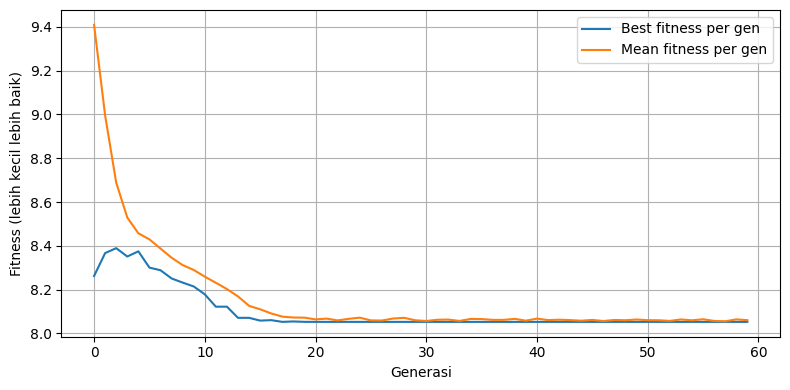

Top solutions saved to: ga_results_10ghz/ga_top10_solutions2.csv


,L_patch_mm,W_patch_mm,inset_x_mm,feed_width_mm,fitness,L_pred,W_pred,h_pred,L_diff,W_diff
0,7.0,9.8,1.478824,3.356771,8.052925,11.383137,13.469789,0.846058,4.383137,3.669789
1,7.0,9.8,1.420359,3.170856,8.052925,11.383137,13.469789,0.846058,4.383137,3.669789
2,7.0,9.8,1.417716,3.183957,8.052925,11.383137,13.469789,0.846058,4.383137,3.669789
3,7.0,9.8,1.552081,3.183155,8.052925,11.383137,13.469789,0.846058,4.383137,3.669789
4,7.0,9.8,1.579997,3.303274,8.052925,11.383137,13.469789,0.846058,4.383137,3.669789
5,7.0,9.8,1.490559,3.260777,8.052925,11.383137,13.469789,0.846058,4.383137,3.669789
6,7.0,9.8,1.465669,3.234035,8.052925,11.383137,13.469789,0.846058,4.383137,3.669789
7,7.0,9.8,1.787734,3.219495,8.052925,11.383137,13.469789,0.846058,4.383137,3.669789
8,7.0,9.8,1.453807,3.207797,8.052925,11.383137,13.469789,0.846058,4.383137,3.669789
9,7.0,9.8,1.440407,3.179145,8.052925,11.383137,13.469789,0.846058,4.383137,3.669789


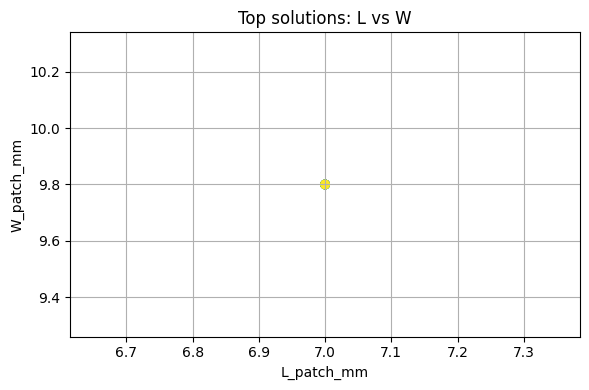

Best solution saved to: ga_results_10ghz/ga_best_solution2.csv
Selesai. Periksa folder ga_results_10ghz untuk file hasil.


In [18]:

# -----------------------------
# 9. Main flow
# -----------------------------
def main():
    print("Memuat dataset...")
    df = load_and_prepare(DATA_CSV)
    print("Dataset shape:", df.shape)
    # Train or load surrogate
    model, scaler_X, scaler_y, split = train_surrogate(df, model_path=MODEL_SAVE, retrain=False)

    # Run GA (note: loop akan memanggil surrogate berulang => cepat)
    print("Menjalankan Genetic Algorithm...")
    final_infos_sorted, best_hist, mean_hist = run_ga(model, scaler_X, scaler_y,
                                                      bounds=BOUNDS, df_train=df,
                                                      pop_size=40, generations=60,
                                                      cx_prob=0.9, mut_prob=0.2, tournament_k=3)

    # Visualize & save top results
    visualize_ga(best_hist, mean_hist, final_infos_sorted)

    # Save best solution detail
    best_ind, best_fit, best_info = final_infos_sorted[0]
    best_params = decode_individual(best_ind)
    best_row = {**best_params, 'fitness':best_fit, 
                'L_pred':best_info['L_pred'], 'W_pred':best_info['W_pred'], 'h_pred':best_info['h_pred'],
                'L_diff':best_info['L_diff'], 'W_diff':best_info['W_diff']}
    pd.DataFrame([best_row]).to_csv(os.path.join(RESULTS_DIR,'ga_best_solution2.csv'), index=False)
    print("Best solution saved to:", os.path.join(RESULTS_DIR,'ga_best_solution2.csv'))
    print("Selesai. Periksa folder", RESULTS_DIR, "untuk file hasil.")

if __name__ == "__main__":
    main()